#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Audio_Final_Project

Mounted at /content/drive
/content/drive/MyDrive/Audio_Final_Project


In [ ]:
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os


#Plotting Functions

In [ ]:
def plot_model_histories(hist_list, names_list, dataset_names, line_styles, colors, data_type):
    """
    Plot training and validation loss for different models and datasets.

    Parameters:
    hist_list (list): List of history objects (dictionaries).
    names_list (list): List of model names.
    dataset_names (list): List of dataset names (e.g., '3_sec', '30_sec').
    line_styles (dict): Dictionary mapping model names to line styles.
    colors (dict): Dictionary mapping model names to colors.
    """
    assert len(hist_list) == len(names_list) == len(dataset_names), "Length of lists and names must be equal"

    keys = set([key for hist in hist_list for key in hist.keys() if 'val_' not in key and 'loss' in key])

    for key in keys:
        plt.figure(figsize=(8, 5))
        for i, (hist, name, dataset_name) in enumerate(zip(hist_list, names_list, dataset_names)):
            if key in hist:
                sns.lineplot(x=range(1, len(hist[key]) + 1), y=hist[key],
                             label=f'{name} {dataset_name} Train', linestyle=line_styles[name], color=colors[name])

            val_key = f'val_{key}'
            if val_key in hist:
                sns.lineplot(x=range(1, len(hist[val_key]) + 1), y=hist[val_key],
                             label=f'{name} {dataset_name} Val', linestyle='--', color=colors[name])

        title = data_type.split('_')[0]
        plt.title(f'{title} Seconds Dataset\n{key.capitalize()} Comparison')
        if len(names_list) == 2:
            if title == '30':
                plt.ylim(0, 5)
            else:
                plt.ylim(0, 1)
        else:
            if title == '30':
                plt.ylim(0, 3)
            else:
                plt.ylim(0, 1)

        plt.xlabel('Epochs')
        plt.ylabel(key.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
def generate_classification_reports(base_path):
    models = ['triplet', 'contrastive', 'regular', 'xgboost']
    datasets = ['3_sec', '30_sec']
    summary_results = {}

    for dataset in datasets:
        print(f"--- Classification reports for {dataset} dataset ---")
        summary_results[dataset] = []

        for model in models:
            if model == "xgboost":
                predictions_file = f'XGBoost_Model/test_classifications/{dataset}_xgboost_predictions.pkl'
                y_test = pickle.load(open(os.path.join(f'datasets/{dataset}_datasets/xgboost_datasets', 'y_test.pkl'), 'rb'))
                label_encoder = LabelEncoder()
                y_true = label_encoder.fit_transform(y_test)
            else:
                predictions_file = os.path.join(base_path, f"{model}_{dataset}.pkl")
                y_test = np.load(f'datasets/{dataset}_datasets/classifier_dataset/y_test.npy')
                y_true = np.argmax(y_test, axis=1)

            if os.path.exists(predictions_file):
                with open(predictions_file, 'rb') as file:
                    predictions = pickle.load(file)

                if predictions.ndim > 1 and predictions.shape[1] > 1:
                    y_pred = np.argmax(predictions, axis=1)
                else:
                    y_pred = predictions

                report = classification_report(y_true, y_pred, output_dict=True)
                print(f"\n{model.capitalize()} Model:")
                print(classification_report(y_true, y_pred, target_names=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']))

                summary_results[dataset].append({
                    'Model': model,
                    'Accuracy': report['accuracy']
                })
            else:
                print(f"Predictions file not found: {predictions_file}")

        summary_df = pd.DataFrame(summary_results[dataset])
        print(f"\nSummary for {dataset} dataset:")
        print(summary_df)
        print("-" * 50)
        print("\n")

    return summary_results

In [12]:
def plot_confusion_matrices(base_path):
    models = ['triplet', 'contrastive', 'regular', 'xgboost']  # Consider XGBoost as a separate model for plotting
    datasets = ['3_sec', '30_sec']
    labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    fig, axes = plt.subplots(nrows=len(datasets), ncols=len(models), figsize=(18, 10))

    for i, dataset in enumerate(datasets):
        for j, model in enumerate(models):
            if model == "xgboost":
                predictions_file = f'XGBoost_Model/test_classifications/{dataset}_xgboost_predictions.pkl'
                y_test = pickle.load(open(os.path.join(f'datasets/{dataset}_datasets/xgboost_datasets', 'y_test.pkl'), 'rb'))
                label_encoder = LabelEncoder()
                y_true = label_encoder.fit_transform(y_test)
            else:
                predictions_file = os.path.join(base_path, f"{model}_{dataset}.pkl")
                y_test = np.load(f'datasets/{dataset}_datasets/classifier_dataset/y_test.npy')
                y_true = np.argmax(y_test, axis=1)

            if os.path.exists(predictions_file):
                with open(predictions_file, 'rb') as file:
                    predictions = pickle.load(file)

                if predictions.ndim == 2 and predictions.shape[1] > 1:
                    y_pred = np.argmax(predictions, axis=1)
                elif predictions.ndim == 1:
                    y_pred = predictions
                else:
                    print(f"Unexpected predictions shape for {model} on {dataset}: {predictions.shape}")
                    continue

                cm = confusion_matrix(y_true, y_pred)

                ax = axes[i, j]
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
                ax.set_title(f'{model.capitalize()} Model ({dataset} dataset)')
                ax.set_xlabel('Predicted labels')
                ax.set_ylabel('True labels')
                ax.set_xticklabels(labels, rotation=45, ha="right")
                ax.set_yticklabels(labels, rotation=0)

                if j == 0:
                    ax.set_ylabel('True labels')
                if i == len(datasets) - 1:
                    ax.set_xlabel('Predicted labels')
            else:
                axes[i, j].set_title(f"Data not found for {model.capitalize()} Model ({dataset} dataset)")
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


#Training Process Comaprison

##Siamese

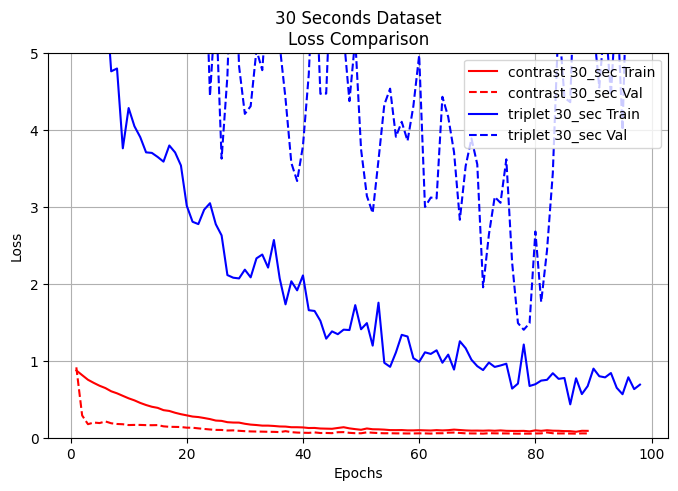

In [ ]:
models = ['contrast', 'triplet']
hist_list = []
names_list = []
dataset_names = []

dataset = '30_sec'
for model in models:
    history_file = f'Siamese_Network/{dataset}/{model}_history.pkl'
    with open(history_file, 'rb') as file:

        history = pickle.load(file)
        hist_list.append(history)
        names_list.append(model)
        dataset_names.append(dataset)


line_styles = {'triplet': '-', 'contrast': '-'}
colors = {'triplet': 'blue', 'contrast': 'red'}

plot_model_histories(hist_list, names_list, dataset_names, line_styles, colors, data_type=dataset)

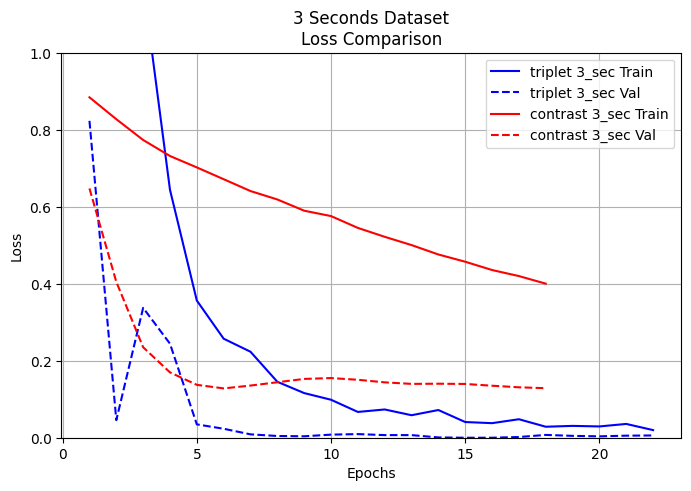

In [ ]:
models = ['triplet', 'contrast']
hist_list = []
names_list = []
dataset_names = []

dataset = '3_sec'
for model in models:
    history_file = f'Siamese_Network/{dataset}/{model}_history.pkl'
    with open(history_file, 'rb') as file:
        history = pickle.load(file)
        hist_list.append(history)
        names_list.append(model)
        dataset_names.append(dataset)


line_styles = {'triplet': '-', 'contrast': '-'}
colors = {'triplet': 'blue', 'contrast': 'red'}

plot_model_histories(hist_list, names_list, dataset_names, line_styles, colors, data_type=dataset)

##Classification

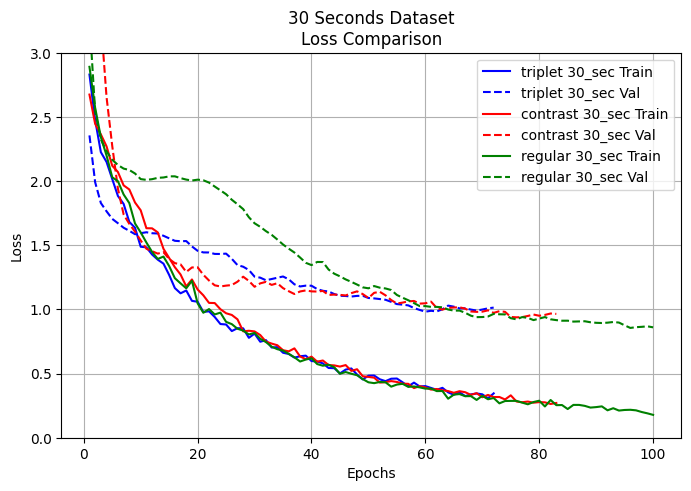

In [ ]:
models = ['triplet', 'contrast', 'regular']
hist_list = []
names_list = []
dataset_names = []

dataset = '30_sec'
for model in models:
    history_file = f'Classifier_Network/{dataset}/{model}_classifier_history.pkl'
    with open(history_file, 'rb') as file:
        history = pickle.load(file)
        hist_list.append(history)
        names_list.append(model)
        dataset_names.append(dataset)


line_styles = {'triplet': '-', 'contrast': '-', 'regular': '-'}
colors = {'triplet': 'blue', 'contrast': 'red', 'regular': 'green'}

plot_model_histories(hist_list, names_list, dataset_names, line_styles, colors, data_type=dataset)

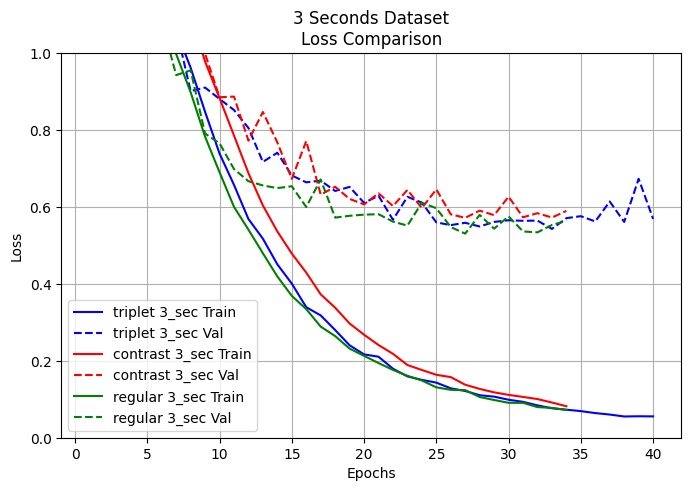

In [ ]:
models = ['triplet', 'contrast', 'regular']
hist_list = []
names_list = []
dataset_names = []

dataset = '3_sec'
for model in models:
    history_file = f'Classifier_Network/{dataset}/{model}_classifier_history.pkl'
    with open(history_file, 'rb') as file:
        history = pickle.load(file)
        hist_list.append(history)
        names_list.append(model)
        dataset_names.append(dataset)


line_styles = {'triplet': '-', 'contrast': '-', 'regular': '-'}
colors = {'triplet': 'blue', 'contrast': 'red', 'regular': 'green'}

plot_model_histories(hist_list, names_list, dataset_names, line_styles, colors, data_type=dataset)

#Classifiers Comparisons

##Metrics Results

In [ ]:
base_path = 'Classifier_Network/test_classifications'
res = generate_classification_reports(base_path)

--- Classification reports for 3_sec dataset ---

Triplet Model:
              precision    recall  f1-score   support

       blues       0.85      0.90      0.87       208
   classical       0.89      0.95      0.92       204
     country       0.74      0.82      0.78       186
       disco       0.77      0.77      0.77       195
      hiphop       0.85      0.88      0.87       236
        jazz       0.88      0.85      0.87       189
       metal       0.91      0.95      0.93       210
         pop       0.80      0.90      0.84       197
      reggae       0.92      0.70      0.79       199
        rock       0.77      0.62      0.69       173

    accuracy                           0.84      1997
   macro avg       0.84      0.83      0.83      1997
weighted avg       0.84      0.84      0.84      1997


Contrastive Model:
              precision    recall  f1-score   support

       blues       0.93      0.76      0.84       208
   classical       0.91      0.96      0.93    

In [ ]:
res

{'3_sec': [{'Model': 'triplet', 'Accuracy': 0.8392588883324987},
  {'Model': 'contrastive', 'Accuracy': 0.8312468703054582},
  {'Model': 'regular', 'Accuracy': 0.8372558838257386},
  {'Model': 'xgboost', 'Accuracy': 0.8913913913913913}],
 '30_sec': [{'Model': 'triplet', 'Accuracy': 0.71},
  {'Model': 'contrastive', 'Accuracy': 0.72},
  {'Model': 'regular', 'Accuracy': 0.695},
  {'Model': 'xgboost', 'Accuracy': 0.77}]}

##Heatmaps Results

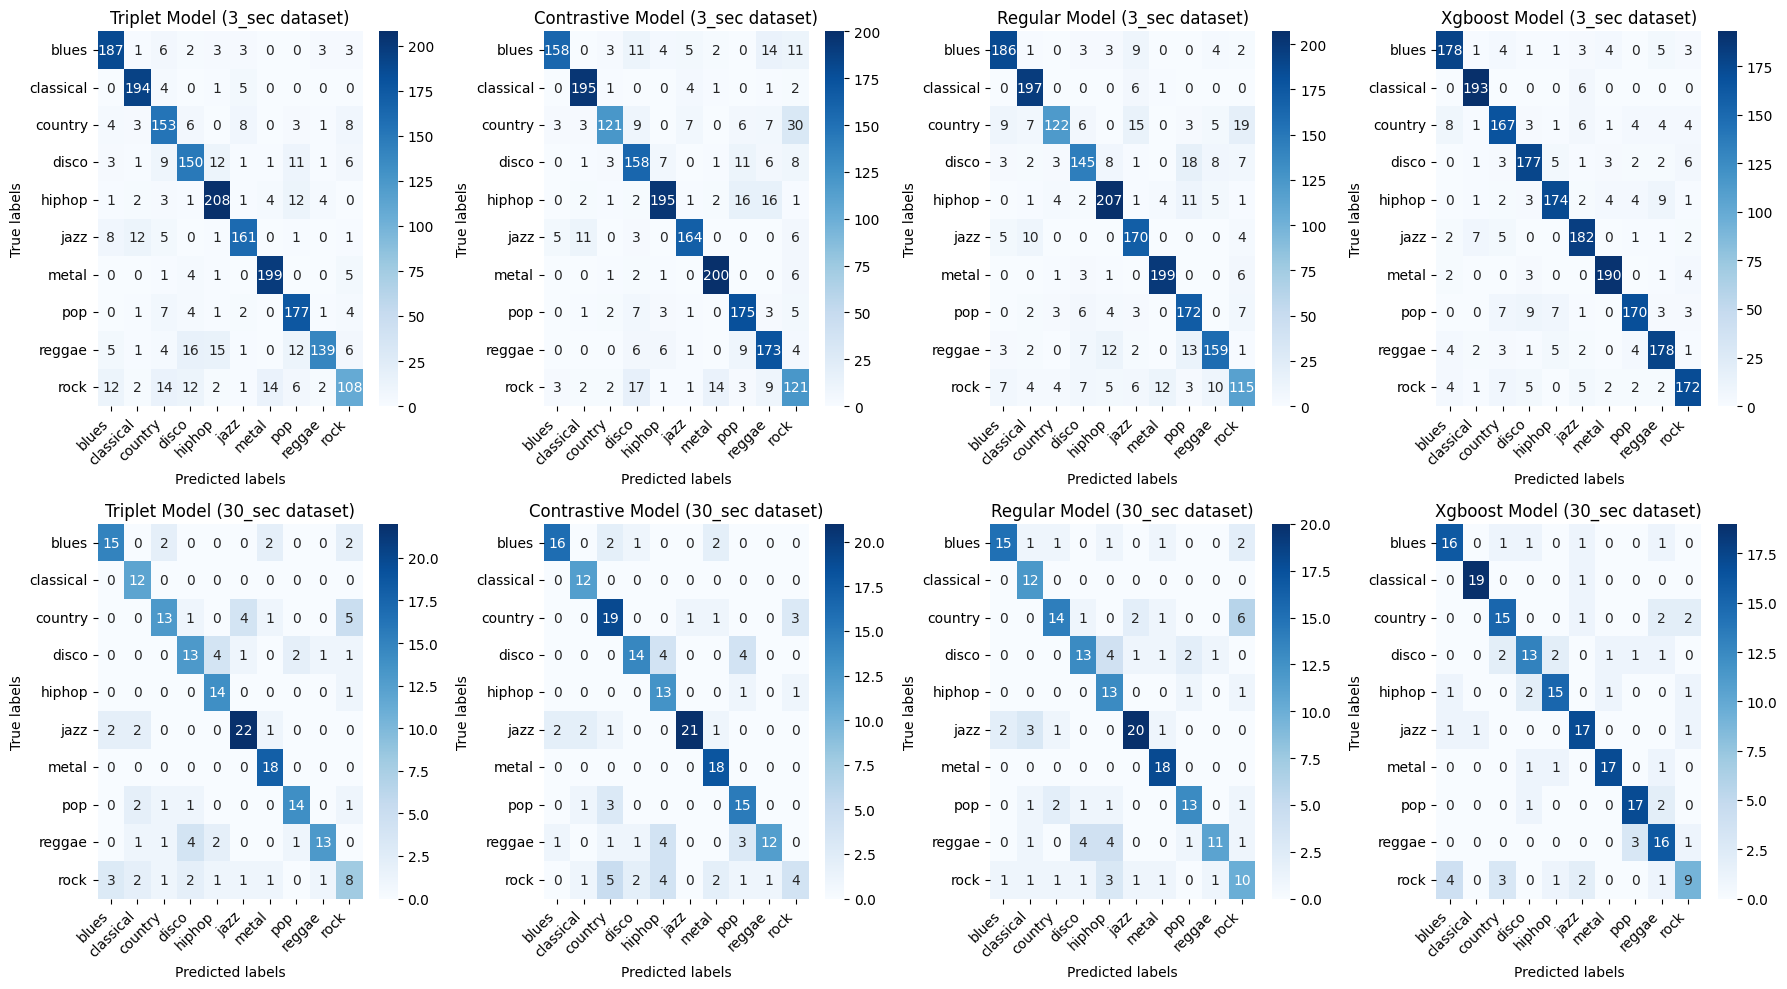

In [13]:
base_path = 'Classifier_Network/test_classifications'
plot_confusion_matrices(base_path)

#Error Analysis

##Confusion Matrix Analysis

In [ ]:
def generate_error_dataframes(base_path):
    models = ['triplet', 'contrastive', 'regular', 'xgboost']
    datasets = ['3_sec', '30_sec']
    classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    fn_df = pd.DataFrame(columns=classes)
    fp_df = pd.DataFrame(columns=classes)

    for dataset in datasets:
        for model in models:
            if model == "xgboost":
                predictions_file = f'XGBoost_Model/test_classifications/{dataset}_xgboost_predictions.pkl'
                y_test = pickle.load(open(os.path.join(f'datasets/{dataset}_datasets/xgboost_datasets', 'y_test.pkl'), 'rb'))
                label_encoder = LabelEncoder()
                y_true = label_encoder.fit_transform(y_test)
            else:
                predictions_file = os.path.join(base_path, f"{model}_{dataset}.pkl")
                y_test = np.load(f'datasets/{dataset}_datasets/classifier_dataset/y_test.npy')
                y_true = np.argmax(y_test, axis=1)

            if os.path.exists(predictions_file):
                with open(predictions_file, 'rb') as file:
                    predictions = pickle.load(file)

                if predictions.ndim > 1 and predictions.shape[1] > 1:
                    y_pred = np.argmax(predictions, axis=1)
                else:
                    y_pred = predictions

                cm = confusion_matrix(y_true, y_pred)
                fn_counts = cm.sum(axis=1) - np.diag(cm)  # Sum of rows minus diagonal elements
                fp_counts = cm.sum(axis=0) - np.diag(cm)  # Sum of columns minus diagonal elements

                fn_df.loc[f'{model}_{dataset}'] = fn_counts
                fp_df.loc[f'{model}_{dataset}'] = fp_counts

    return fn_df, fp_df

base_path = 'Classifier_Network/test_classifications'
fn_df, fp_df = generate_error_dataframes(base_path)

In [ ]:
from IPython.display import display, HTML

display(HTML(fn_df.to_html()))
display(HTML(fp_df.to_html()))

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
triplet_3_sec,21,10,33,45,28,28,11,20,60,65
contrastive_3_sec,50,9,65,37,41,25,10,22,26,52
regular_3_sec,22,7,64,50,29,19,11,25,40,58
xgboost_3_sec,22,6,32,23,26,18,10,30,22,28
triplet_30_sec,6,0,11,9,1,5,0,5,9,12
contrastive_30_sec,5,0,5,8,2,6,0,4,10,16
regular_30_sec,6,0,10,9,2,7,0,6,11,10
xgboost_30_sec,4,1,5,7,5,3,3,3,4,11


,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
triplet_3_sec,33,23,53,45,36,22,19,45,12,33
contrastive_3_sec,11,20,13,57,22,20,20,45,56,73
regular_3_sec,27,29,15,34,33,43,17,48,32,47
xgboost_3_sec,20,14,31,25,19,26,14,17,27,24
triplet_30_sec,5,7,5,8,7,6,5,3,2,10
contrastive_30_sec,3,4,12,4,12,1,6,9,1,4
regular_30_sec,3,7,5,7,13,4,5,4,2,11
xgboost_30_sec,6,1,6,5,4,5,2,4,8,5


**Insights based on the False Negatives (FN) and False Positives (FP) tables:**

- High FN and FP for 'Rock' and 'Reggae' in the 3-sec dataset: Both genres have high false negatives and false positives in the 3-second dataset, particularly for the 'triplet' and 'regular' models. This suggests that these genres are particularly challenging to classify correctly in short audio clips, possibly due to overlapping musical characteristics with other genres.

- Classical Music Classification: 'Classical' shows relatively low FN and FP across models and datasets, indicating that this genre is easier to distinguish, likely due to distinct characteristics that set it apart from other genres.

- Country Music Challenges: The 'country' genre shows a high number of FNs, especially in the 3-second clips, suggesting that it's often confused with other genres. However, its FP rates are not as elevated, indicating that while it's often missed, other genres are not frequently misclassified as 'country.'

- Disco and HipHop: Both genres show moderate to high FN and FP in the 3-second dataset but lower rates in the 30-second dataset. This could imply that longer audio samples provide more distinctive features that help the models to classify these genres more accurately.

- Performance with Metal: 'Metal' tends to have low FN and FP across both datasets, which might suggest that its distinctive features are well-captured by the models, even in shorter audio clips.

- mpact of Audio Clip Length: Generally, the 30-second clips show lower FN and FP rates across genres, indicating that longer audio samples provide more context and distinctive features for accurate classification. However, the degree of improvement varies across genres, suggesting that some genres benefit more from the additional context than others.

- Model-Specific Observations: The 'xgboost' model tends to have lower FN and FP rates compared to other models, especially in the 30-second dataset, suggesting it may be better at utilizing the additional context in longer audio samples. However, it's not uniformly better across all genres and timeframes.

In [ ]:
def find_top_misclassified_pairs(base_path, models, dataset, class_labels):
    for model in models:
        print(f"\n--- Top misclassified pairs for model {model} on dataset {dataset} ---")
        aggregated_cm = np.zeros((len(class_labels), len(class_labels)))

        if model == "xgboost":
            predictions_file = f'XGBoost_Model/test_classifications/{dataset}_xgboost_predictions.pkl'
            y_test = pickle.load(open(os.path.join(f'datasets/{dataset}_datasets/xgboost_datasets', 'y_test.pkl'), 'rb'))
            label_encoder = LabelEncoder()
            y_true = label_encoder.fit_transform(y_test)
        else:
            predictions_file = os.path.join(base_path, f"{model}_{dataset}.pkl")
            y_test = np.load(f'datasets/{dataset}_datasets/classifier_dataset/y_test.npy')
            y_true = np.argmax(y_test, axis=1)

        if os.path.exists(predictions_file):
            with open(predictions_file, 'rb') as file:
                predictions = pickle.load(file)

            if predictions.ndim == 2 and predictions.shape[1] > 1:
                y_pred = np.argmax(predictions, axis=1)
            elif predictions.ndim == 1:
                y_pred = predictions
            else:
                print(f"Unexpected predictions shape for {model} on dataset {dataset}: {predictions.shape}")
                continue

            cm = confusion_matrix(y_true, y_pred, labels=range(len(class_labels)))
            aggregated_cm += cm

            sum_missed = aggregated_cm.sum() - np.trace(aggregated_cm)
            misclassification_pairs = []
            for i in range(len(class_labels)):
                for j in range(len(class_labels)):
                    if i != j:
                        misclassification_pairs.append(((class_labels[i], class_labels[j]), aggregated_cm[i, j]))

            misclassification_pairs.sort(key=lambda x: x[1], reverse=True)

            # Print the top N misclassified pairs for the current model
            top_n = 5
            for i in range(top_n):
                pct_missed = misclassification_pairs[i][1] / sum_missed * 100
                print(f"Pair {misclassification_pairs[i][0]} was misclassified {pct_missed:.2f}% of the time")

# Usage example
base_path = 'Classifier_Network/test_classifications'
models = ['triplet', 'contrastive', 'regular', 'xgboost']
datasets = ['3_sec', '30_sec']
class_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for dataset in datasets:
    find_top_misclassified_pairs(base_path, models, dataset, class_labels)
    print("- - - " * 20)


--- Top misclassified pairs for model triplet on dataset 3_sec ---
Pair ('reggae', 'disco') was misclassified 4.98% of the time
Pair ('reggae', 'hiphop') was misclassified 4.67% of the time
Pair ('rock', 'country') was misclassified 4.36% of the time
Pair ('rock', 'metal') was misclassified 4.36% of the time
Pair ('disco', 'hiphop') was misclassified 3.74% of the time

--- Top misclassified pairs for model contrastive on dataset 3_sec ---
Pair ('country', 'rock') was misclassified 8.90% of the time
Pair ('rock', 'disco') was misclassified 5.04% of the time
Pair ('hiphop', 'pop') was misclassified 4.75% of the time
Pair ('hiphop', 'reggae') was misclassified 4.75% of the time
Pair ('blues', 'reggae') was misclassified 4.15% of the time

--- Top misclassified pairs for model regular on dataset 3_sec ---
Pair ('country', 'rock') was misclassified 5.85% of the time
Pair ('disco', 'pop') was misclassified 5.54% of the time
Pair ('country', 'jazz') was misclassified 4.62% of the time
Pair (

Insights for Dataset 3_sec

- **Triplet Model:** The model frequently confuses 'reggae' with 'disco' and 'hiphop', and 'rock' with 'country' and 'metal'. This suggests that the acoustic features extracted for these 3-second clips might not be distinct enough for the model to differentiate between these genres effectively.

- **Contrastive Model:** This model has a notable confusion between 'country' and 'rock', which is the most significant error. The model also confuses 'hiphop' with 'pop' and 'reggae', and 'blues' with 'reggae'. It indicates that the contrastive model might be picking up on similar rhythmic or instrumental characteristics between these pairs.

- **Regular Model:** Like the contrastive model, it also significantly confuses 'country' with 'rock'. Misclassifications between 'disco' and 'pop', and 'country' and 'jazz' are also prevalent. This pattern might point to a blending of genre-specific features in these short clips that the model cannot disentangle.

- **XGBoost:** This model shows a relatively balanced confusion across different pairs, with 'hiphop' and 'reggae', and 'pop' and 'disco' being the top confusions. It suggests that XGBoost may struggle with specific genre pair separations across the board.

Insights for Dataset 30_sec

- **Triplet Model:** The confusion between 'country' and 'rock' is significant, as well as between 'country' and 'jazz'. The longer 30-second clips do not seem to alleviate the confusion for 'country' with other genres, suggesting inherent similarities in their 30-second features.

- **Contrastive Model:** There's a high misclassification between 'rock' and 'country', and significant confusion involving 'disco', 'hiphop', and 'pop'. The persistent confusion between 'rock' and 'country' across models indicates a strong similarity in their 30-second segments.

- **Regular Model:** Similar to the 3-second dataset, 'country' and 'rock' are frequently confused. Misclassifications involving 'disco', 'hiphop', and 'reggae' suggest that the model might be picking up on similar beat or tempo features.

- **XGBoost:** 'Rock' and 'blues' show the highest confusion, followed by 'reggae' with 'pop' and 'rock' with 'country'. This pattern suggests that, for the XGBoost model, the 30-second segments do not provide clear enough distinctions for these genres.

General Observations

- Across both datasets, 'country' and 'rock' are frequently confused by various models, which could suggest a fundamental similarity in their musical features over both short and longer segments. 'Disco' and 'hiphop', as well as 'reggae' and 'pop', also appear frequently as confused pairs, indicating potential crossover in their defining musical characteristics.

- Each model has its own specific genres that it struggles with, indicating differences in how they learn and interpret the features from the audio segments.

- The length of the audio clips (3 seconds vs. 30 seconds) does not uniformly improve the classification for all genres. While one might expect longer clips to provide more context and lead to better classification, this is not universally observed, suggesting that the extracted features or the models' learning mechanisms might not be fully capitalizing on the longer context.


##Analysis of Conv Layers

In [ ]:
def build_conv_branch(name, input_shape):
    model = Sequential(name=name)
    # Layer 1
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    return model

def load_conv_layer(input_shape, weights_path, branch_name):
    input_1 = Input(input_shape)
    branch_1 = build_conv_branch(name=branch_name, input_shape=input_shape)
    branch_1.load_weights(weights_path)
    outputs = branch_1(input_1)

    model = Model(inputs=input_1, outputs=outputs)
    return model

In [ ]:
def visualize_conv_layer_outputs_subplot(models, datasets, n_components, class_names, pct_from_test):
    fig, axs = plt.subplots(nrows=len(datasets), ncols=len(models), figsize=(12, 8), subplot_kw={'projection': '3d'} if n_components == 3 else {})

    # Used for collecting legend information
    scatter_plots = []

    for i, dataset in enumerate(datasets):
        X_test = np.load(f'datasets/{dataset}_datasets/classifier_dataset/X_test.npy')
        X_test = X_test[:int(X_test.shape[0] * pct_from_test)]

        y_test = np.load(f'datasets/{dataset}_datasets/classifier_dataset/y_test.npy')
        y_test = np.argmax(y_test, axis=1)
        y_test = y_test[:int(y_test.shape[0] * pct_from_test)]

        for j, model_name in enumerate(models):
            weights_path = f'Siamese_Network/{dataset}/{model_name}_branch.h5'
            branch_name = f'{model_name}_branch'

            model = load_conv_layer(X_test.shape[1:], weights_path, branch_name)

            conv_outputs = model.predict(X_test)
            flat_outputs = conv_outputs.reshape(conv_outputs.shape[0], -1)

            tsne = TSNE(n_components=n_components, random_state=42)
            reduced_data = tsne.fit_transform(flat_outputs)

            label_encoder = LabelEncoder()
            y_test_encoded = label_encoder.fit_transform(y_test)

            ax = axs[i, j] if len(datasets) > 1 else axs[j]
            scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2] if n_components == 3 else None, c=y_test_encoded, cmap='tab10')
            ax.set_title(f'{model_name} - {dataset}')

            if n_components == 2:
                ax.set_xlabel('Component 1')
                ax.set_ylabel('Component 2')

            scatter_plots.append(scatter)

    handles, labels = scatter_plots[0].legend_elements()
    new_labels = [class_names[int(label)] for label in np.unique(y_test_encoded)]
    fig.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(class_names))

    plt.tight_layout()
    plt.show()

models = ['triplet', 'contrast']
datasets = ['3_sec', '30_sec']
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

7/7 [==============================] - 0s 11ms/step


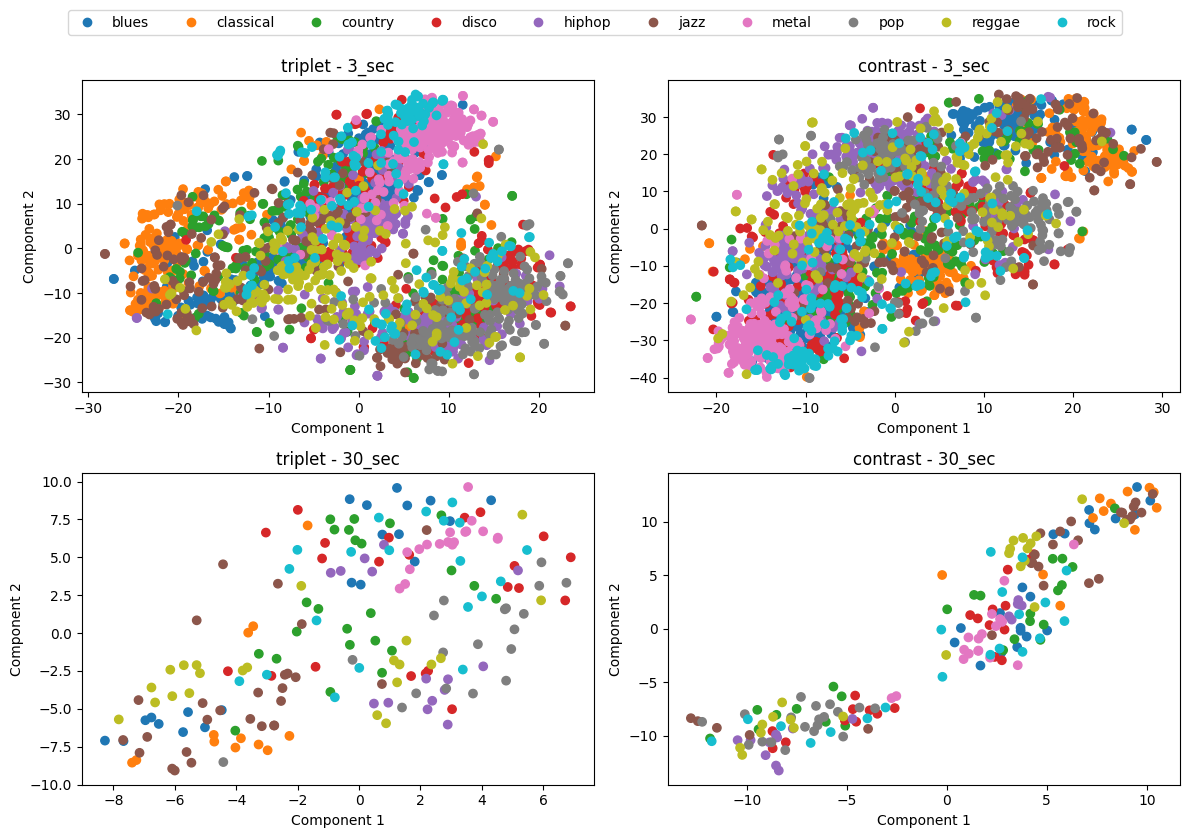

In [ ]:
visualize_conv_layer_outputs_subplot(models, datasets, 2, class_names, pct_from_test=1)

7/7 [==============================] - 0s 11ms/step


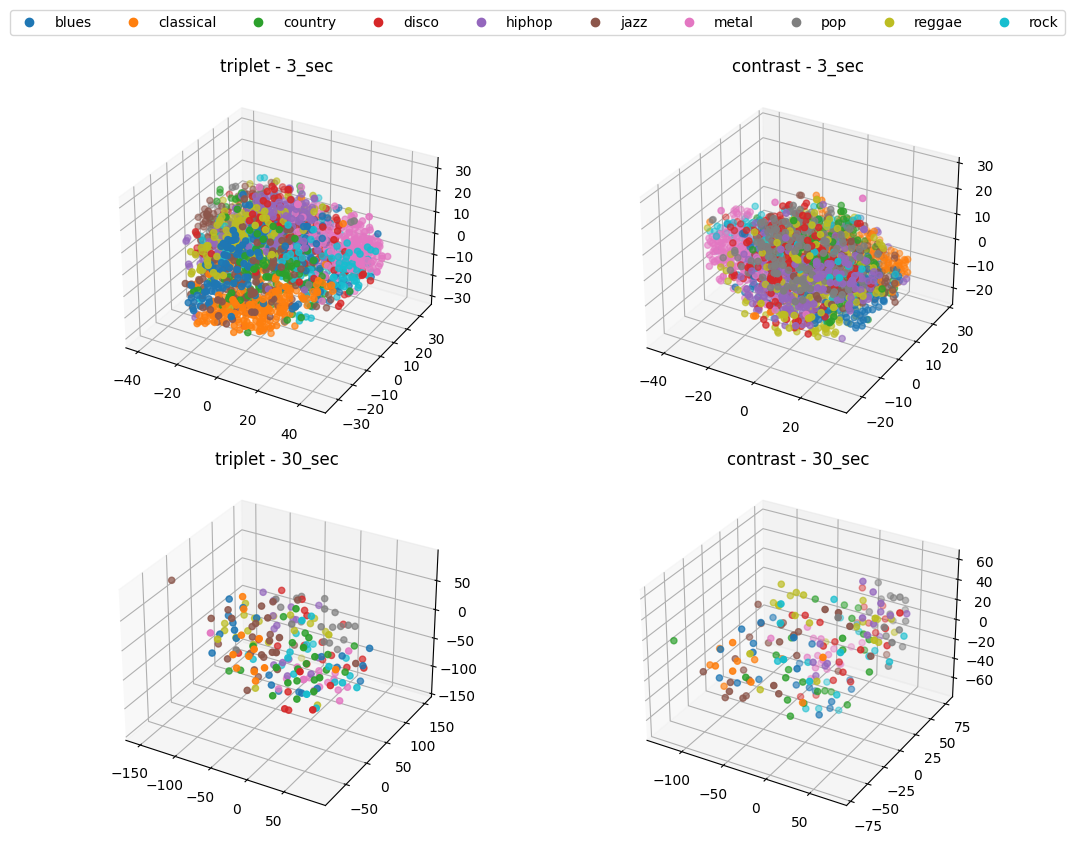

In [ ]:
visualize_conv_layer_outputs_subplot(models, datasets, 3, class_names, pct_from_test=1)

**Insights**


In the presented two-dimensional t-SNE visualizations, we observe discernible patterns in the spatial distribution of genres across different models and temporal scales. Within the 30-second dataset, the Triplet model demonstrates a wider dispersion of data points, as opposed to the Contrast model, which exhibits denser clustering. The latter appears to more effectively co-locate instances within their respective genre categories, suggesting a higher fidelity in capturing genre-defining features.

Conversely, the 3-second dataset reveals a notable degree of class separation, with the exception of 'reggae' and 'rock' for both models. This outcome is indicative of the inherent challenge in distinguishing between these particular genres within shorter audio samples. Notably, the Triplet model adeptly consolidates 'classical' genre instances, a genre which previously exhibited high misclassification rates, whereas the Contrast model displays a bifurcated distribution pattern for the same genre.

Extending to the three-dimensional t-SNE projections, additional insights remain elusive; the spatial relations observed in two dimensions largely persist. For the 3-second samples, the Triplet model maintains a propensity for tighter grouping, contrasting with the Contrast model, which portrays a more diffuse spread of data points. This tendency is consistent across both the 3-second and 30-second datasets.

These observations provide a nuanced understanding of model performance and underscore the complexity of automated genre classification. They accentuate the potential trade-offs between model architectures in terms of cluster density and boundary definition, which merit further investigation for enhancement of classification accuracy and robustness.